<a href="https://colab.research.google.com/github/xiaolancara/Recommender-System/blob/main/%E2%80%9CRecommendation_systems_colab_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Recommendation Systems

In [ ]:
#@title Copyright
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Recommendation Systems with TensorFlow

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

If possible, use a runtime with a GPU. This can be done using **Runtime**->**Change runtime type** and choosing GPU.

# Introduction

We will create a movie recommendation system based on the [MovieLens](https://movielens.org/) dataset available [here](http://grouplens.org/datasets/movielens/).  The data consists of movies ratings (on a scale of 1 to 5).

## Outline
  1. Exploring the MovieLens Data
  1. Preliminaries
  1. Training a matrix factorization model
  1. Inspecting the model
  1. Importance of Regularization

## Setup

Let's get started by importing the required packages.

In [1]:
# @title Imports
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.disable_eager_execution()

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

# Install and import UMAP for embedding visualization.
print("Installing UMAP...")
!pip install umap-learn
import umap
print("Done installing UMAP.")

# Altair visualization code
# The following functions are used to generate interactive Altair charts.
# We will display histograms of the data, sliced by a given attribute.

# Create filters to be used to slice the data.
occupation_filter = alt.selection_multi(fields=["occupation"])
# sort=alt.SortField(op="count", order='ascending')
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

def hist(field, label):
  return alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )

# A function that generates a histogram of filtered data.
def filtered_hist(field, label, filter):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')

# A utility to filter movies by genre.
genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

Done installing UMAP.


We then download the MovieLens Data, and create DataFrames containing movies, users, and ratings.

In [2]:
# @title Load the MovieLens data

# Download MovieLens data.
print("Downloading movielens data...")
import urllib.request
import zipfile

urllib.request.urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info').decode('utf-8'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

Done. Dataset contains:
943 users
1682 items
100000 ratings



# I. Exploring the Movielens Data
Before we dive into model building, let's inspect our MovieLens dataset. It is usually helpful to understand the statistics of the dataset.

### Users
We start by printing some basic statistics describing the numeric and categorical user features.

In [3]:
users.describe(include=[np.object, int])

,user_id,age,sex,occupation,zip_code
count,943,943.000,943,943,943
unique,943,nan,2,21,795
top,377,nan,M,student,55414
freq,1,nan,670,196,9
mean,NaN,34.052,NaN,NaN,NaN
...,...,...,...,...,...
min,NaN,7.000,NaN,NaN,NaN
25%,NaN,25.000,NaN,NaN,NaN
50%,NaN,31.000,NaN,NaN,NaN
75%,NaN,43.000,NaN,NaN,NaN


Next, we look at the distribution of ratings per user. Clicking on an occupation in the right chart will filter the data by that occupation. The corresponding histogram is shown in blue, and superimposed with the histogram for the whole data (in light gray). You can use SHIFT+click to select multiple subsets.

What do you observe, and how might this affect the recommendations?

In [4]:
users_ratings = users.merge(
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='user_id')

# Create a chart for the count, and one for the mean.
alt.hconcat(
    hist('rating count', '# ratings / user'),
    hist('rating mean', 'mean user rating'),
    data=users_ratings)

alt.HConcatChart(...)

### Movies

It is also useful to look at information about the movies and their ratings.

In [ ]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

display.display(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

display.display(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

,title,rating count,rating mean
49,Star Wars (1977),583,4.358
257,Contact (1997),509,3.804
99,Fargo (1996),508,4.156
180,Return of the Jedi (1983),507,4.008
293,Liar Liar (1997),485,3.157
285,"English Patient, The (1996)",481,3.657
287,Scream (1996),478,3.441
0,Toy Story (1995),452,3.878
299,Air Force One (1997),431,3.631
120,Independence Day (ID4) (1996),429,3.438


,title,rating count,rating mean
407,"Close Shave, A (1995)",112,4.491
317,Schindler's List (1993),298,4.466
168,"Wrong Trousers, The (1993)",118,4.466
482,Casablanca (1942),243,4.457
113,Wallace & Gromit: The Best of Aardman Animatio...,67,4.448
63,"Shawshank Redemption, The (1994)",283,4.445
602,Rear Window (1954),209,4.388
11,"Usual Suspects, The (1995)",267,4.386
49,Star Wars (1977),583,4.358
177,12 Angry Men (1957),125,4.344


Finally, the last chart shows the distribution of the number of ratings and average rating.

In [ ]:
# Display the number of ratings and average rating per movie.
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

alt.HConcatChart(...)

# II. Preliminaries

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each rwo $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.



### Exercise: Sparse Representation of the Rating Matrix

The rating matrix could be very large and, in general, most of the entries are unobserved, since a given user will only rate a small subset of movies. For effcient representation, we will use a [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor). A `SparseTensor` uses three tensors to represent the matrix: `tf.SparseTensor(indices, values, dense_shape)` represents a tensor, where a value $A_{ij} = a$ is encoded by setting `indices[k] = [i, j]` and `values[k] = a`. The last tensor `dense_shape` is used to specify the shape of the full underlying matrix.

#### Toy example
Assume we have $2$ users and $4$ movies. Our toy ratings dataframe has three ratings,

user\_id | movie\_id | rating
--:|--:|--:
0 | 0 | 5.0
0 | 1 | 3.0
1 | 3 | 1.0

The corresponding rating matrix is

$$
A =
\begin{bmatrix}
5.0 & 3.0 & 0 & 0 \\
0   &   0 & 0 & 1.0
\end{bmatrix}
$$

And the SparseTensor representation is,
```python
SparseTensor(
  indices=[[0, 0], [0, 1], [1,3]],
  values=[5.0, 3.0, 1.0],
  dense_shape=[2, 4])
```


**Exercise** Write a function that maps from the `ratings` DataFrame to a `tf.SparseTensor`.

Hint: you can select the values of a given column of a Dataframe `df` using `df['column_name'].values`.

In [ ]:
def build_rating_sparse_tensor(ratings):
  """
  Args:
    ratings: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    A tf.SparseTensor representing the ratings matrix.
  """
  # ========================= Complete this section ============================
  # indices =
  # values =
  # ============================================================================

  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

In [ ]:
#@title Solution
def build_rating_sparse_tensor(ratings):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings[['user_id', 'movie_id']].values
  values = ratings['rating'].values.astype(np.float32)
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

### Exercise: Compute the Mean Squared Error


The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only (we will revisit this later). It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.

**Exercise:** Write a TensorFlow function that takes a sparse rating matrix $A$ and the two embedding matrices $U, V$ and returns the mean squared error $\text{MSE}(A, UV^\top)$.

Hints:
  * in this section, we only consider observed entries when calculating the loss.
  * a `SparseTensor` `sp_x` is a tuple of three Tensors: `sp_x.indices`, `sp_x.values` and `sp_x.dense_shape`.
  * you may find [`tf.gather_nd`](https://www.tensorflow.org/api_docs/python/tf/gather_nd) and  [`tf.losses.mean_squared_error`](https://www.tensorflow.org/api_docs/python/tf/losses/mean_squared_error) helpful.

In [ ]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  # ========================= Complete this section ============================
  # loss =
  # ============================================================================
  return loss

In [ ]:
#@title Solution
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),  # prediction matrix
      sparse_ratings.indices)  # observed part of the ground truth matrix
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

# III. Training a Matrix Factorization model

## CFModel (Collaborative Filtering Model) helper class
This is a simple class to train a matrix factorization model using stochastic gradient descent.

The class constructor takes
- the user embeddings U (a `tf.Variable`).
- the movie embeddings V, (a `tf.Variable`).
- a loss to optimize (a `tf.Tensor`).
- an optional list of metrics dictionaries, each mapping a string (the name of the metric) to a tensor. These are evaluated and plotted during training (e.g. training error and test error)

After training, one can access the trained embeddings using the `model.embeddings` dictionary.

Example usage:
```
U = ...
V = ...
loss = ...
model = CFModel(U, V, loss)
model.train(iterations=100, learning_rate=1.0)
user_embeddings = model.embeddings['user_id']
movie_embeddings = model.embeddings['movie_id']
```


In [ ]:
#@title CFModel class
%matplotlib inline

class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, U, V, loss, metrics):
    """Initializes a CFModel.
    Args:
      U: tf.Variable of the user embeddings.
      V: tf.Variable of the movie embeddings.
      loss: A float Tensor. The loss to optimize.
      metrics: list of metric dicts. Each dict maps the metric name to a tensor,
        and will be computed and displayed in a separate figure during training.
    """
    self._embeddings = {"user_id": U, "movie_id": V}
    self._loss = loss
    self._graph = loss.graph
    self._session = tf.Session()
    if not isinstance(metrics, list):
      metrics = [metrics]
    self._metrics = metrics
    self._metrics_vals = [collections.defaultdict(list) for _ in metrics]
    self._step = tf.Variable(0)
    self._steps = []

    # Initialize variables and queue runners.
    with self._session.as_default():
      self._session.run(tf.global_variables_initializer())
      self._session.run(tf.tables_initializer())
      tf.train.start_queue_runners()

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._session.run(self._embeddings)

  def _update_results(self, axs):
    """Computes the metrics and updates the figures."""
    self._steps.append(self._session.run(self._step))
    metrics = self._session.run(self._metrics)
    for metric_val, result in zip(self._metrics_vals, metrics):
      for k, v in result.items():
        metric_val[k].append(v)
    if axs is not None:
      # Plot the metrics.
      display.clear_output(wait=True)
      for metric_vals, ax in zip(self._metrics_vals, axs):
        ax.clear()
        ax.set_xlim([1, max(self._steps)])
        for k, v in metric_vals.items():
          ax.plot(self._steps, v, label=k)
        ax.legend()
      display.display(plt.gcf())
    # print("iteration %d:" % i)
    for m in metrics:
      for k, v in m.items():
        print("%s \t = %f" % (k, v))

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      num_iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Defaults to GradientDescentOptimizer.
    """
    with self._graph.as_default():
      opt = optimizer(learning_rate)
      train_op = tf.group(opt.minimize(self._loss), tf.assign_add(self._step, 1))
      local_init_op = tf.group(
        tf.local_variables_initializer(),
        tf.variables_initializer(opt.variables()))

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      # Create figure.
      num_subplots = len(self._metrics)+1
      fig = plt.figure(1)
      fig.set_size_inches(num_subplots*6, 5)
      if plot_results:
        axs = [fig.add_subplot(1, num_subplots, i) for i in range(1, num_subplots)]
      else:
        axs = None
      # Train and update figure.
      for i in range(num_iterations):
        self._session.run(train_op)
        if num_iterations and (20 * i % num_iterations == 0):
          self._update_results(axs)
      self._update_results(axs)
      plt.close(1)  # to avoid displaying a duplicate figure.


def get_recall(U, V, sp_x, k=10):
  """Creates a recall metrics for a given data matrix."""
  predictions = tf.matmul(U, V, transpose_b=True)
  labels = tf.sparse.reorder(tf.SparseTensor(
      indices=sp_x.indices,
      values=sp_x.indices[:, 1],
      dense_shape=sp_x.dense_shape))
  _, recall = tf.metrics.recall_at_k(labels, predictions, k=k)
  return recall


# Visualization code

def movie_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    models: A list of MFModel objects.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'title': movies['title'],
      'genre': movies['genre'],
      'num_ratings': movies_ratings['rating count'],
  })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["movie_id"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

def visualize_movie_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["movie_id"])
  movies.loc[:,'x'] = V_proj[:, 0]
  movies.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(movies, 'x', 'y')

def umap_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using UMAP with Cosine measure.
  Args:
    model: A MFModel object.
  """
  print('Running UMAP...')
  V_proj = (umap
            .UMAP(n_neighbors=8, n_components=2, min_dist=0.25, metric='cosine')
            .fit_transform(model.embeddings["movie_id"]))
  movies.loc[:,'x'] = V_proj[:, 0]
  movies.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(movies, 'x', 'y')

def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0]*V.shape[0]) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

### Exercise: Build a Matrix Factorization model and train it

Using your `sparse_mean_square_error` function, write a function that builds a `CFModel` by creating the embedding variables and the train and test losses.

In [ ]:
def build_model(
    ratings, embedding_dim=3, regularization_coeff=0, gravity_coeff=0,
    init_stddev=1.):
  """
  Args:
    ratings: The DataFrame of ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
    init_stddev: The standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  # ========================= Complete this section ============================
  # A_train =
  # A_test =
  # ============================================================================
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  # ========================= Complete this section ============================
  # error_train =
  # error_test = 
  # ============================================================================
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0] + tf.reduce_sum(V*V)/V.shape[0])
  total_loss = error_train + regularization_loss + gravity_loss
  # metrics = 
  return CFModel(U, V, total_loss, metrics)

In [ ]:
# @title Solution
def build_model(
    ratings, embedding_dim=3, regularization_coeff=0, gravity_coeff=0,
    init_stddev=1.0, recall_position=None):
  """
  Args:
    ratings: The DataFrame of ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
    init_stddev: The standard deviation of the random initial embeddings.
  Returns:
    A CFModel object.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings, holdout_fraction=0.2)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  train_error = sparse_mean_square_error(A_train, U, V)
  test_error = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0] + tf.reduce_sum(V*V)/V.shape[0])
  total_loss = train_error + regularization_loss + gravity_loss
  metrics = [{
      'train_error': train_error,
      'test_error': test_error,
  },
  {
      'train_observed_loss': train_error,
      'train_reg_loss': regularization_loss,
      'train_gravity_loss': gravity_loss,
  }]
  if recall_position:
    metrics.append({
        'train R@{}'.format(recall_position): get_recall(U, V, A_train, recall_position),
        'test R@{}'.format(recall_position): get_recall(U, V, A_test, recall_position),
    })
  embeddings = {"user_id": U, "movie_id": V}

  return CFModel(U, V, total_loss, metrics)

Great, now it's time to train the model!

Go ahead and run the next cell, trying different parameters (embedding dimension, learning rate, iterations). The training and test errors are plotted during training. You can inspect these values to validate the hyper-parameters.

Note: by calling `model.train` on the same model again, the model will continue training starting from the current values of the embeddings.

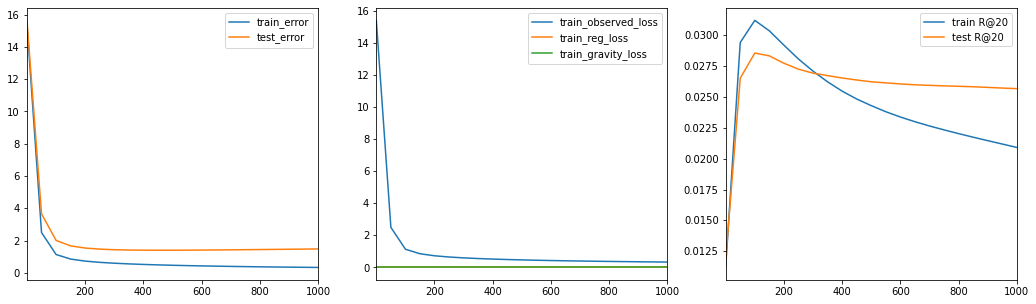

train_error 	 = 0.335935
test_error 	 = 1.482364
train_observed_loss 	 = 0.335935
train_reg_loss 	 = 0.000000
train_gravity_loss 	 = 0.000000
train R@20 	 = 0.020915
test R@20 	 = 0.025681


In [ ]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=30, init_stddev=0.5, recall_position=20)
results = model.train(num_iterations=1000, learning_rate=10.)

You will notice that although the train and test errors decrease over time, the train and test recall increase for the first iterations then start to decrease. As we will see, this is mainly due to the choice of loss function.

# IV. Inspecting the Model

In this section, we take a closer look at the learned embeddings, by
- looking at the nearest neighbors of some movies,
- looking at the norms of the movie embeddings,
- visualizing the embedding in a projected embedding space.

#### Exercise: Write a function that computes candidate scores
We start by writing a function that, given a query embedding $u \in \mathbb R^d$ and item embeddings $V \in \mathbb R^{N \times d}$, computes the item scores.

As discussed in the lecture, there are different similarity measures we can use, and these can yield different results. We will compare the following:
- dot product: the score of item j is $\langle u, V_j \rangle$.
- cosine: the score of item j is $\frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$.

Hints:
- you can use [`np.dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) to compute the product of two np.Arrays.
- you can use [`np.linalg.norm`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.norm.html) to compute the norm of a np.Array.

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  # ========================= Complete this section ============================
  # scores =
  # ============================================================================
  return scores

In [ ]:
#@title Solution
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

### Movie Nearest neighbors

Let's look at the neareast neighbors for some of the movies.

In [ ]:
# @title Nearest neighbors
def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  all_titles = movies['title'].str.lower()
  ids =  movies[all_titles.str.contains(title_substring.lower())].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
movie_neighbors(model, "Aladdin", DOT)
movie_neighbors(model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,dot score,titles,genres
94,6.992,Aladdin (1992),Animation-Children-Comedy-Musical
49,6.120,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
171,5.928,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
173,5.768,Raiders of the Lost Ark (1981),Action-Adventure
180,5.691,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War
248,5.626,Austin Powers: International Man of Mystery (1...,Comedy


Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,cosine score,titles,genres
94,1.000,Aladdin (1992),Animation-Children-Comedy-Musical
173,0.845,Raiders of the Lost Ark (1981),Action-Adventure
0,0.835,Toy Story (1995),Animation-Children-Comedy
49,0.825,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
180,0.806,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War
300,0.792,In & Out (1997),Comedy


It seems that the quality of learned embeddings may not be very good. This will be addressed in Section V by adding several regularization techniques. First, we will further inspect the embeddings.

## Movie Embedding Norm

We can also observe that the recommendations with dot-product and cosine are different: with dot-product, the model tends to recommend popular movies. This can be explained by the fact that in matrix factorization models, the norm of the embedding is often correlated with popularity (popular movies have a larger norm), which makes it more likely to recommend more popular items. We can confirm this hypothesis by sorting the movies by their embedding norm, as done in the next cell.

In [ ]:
movie_embedding_norm(model)

alt.HConcatChart(...)

Note: Depending on how the model is initialized, you may observe that some niche movies (ones with few ratings) have a high norm, leading to spurious recommendations. This can happen if the embedding of that movie happens to be initialized with a high norm. Then, because the movie has few ratings, it is infrequently updated, and can keep its high norm. This will be alleviated by using regularization.

Try changing the value of the hyper-parameter `init_stddev`. One quantity that can be helpful is that the expected norm of a $d$-dimensional vector with entries $\sim \mathcal N(0, \sigma^2)$ is approximatley $\sigma \sqrt d$.

How does this affect the embedding norm distribution, and the ranking of the top-norm movies?

## Embedding visualization
Since it is hard to visualize embeddings in a higher-dimensional space (when the embedding dimension $k > 3$), one approach is to project the embeddings to a lower dimensional space. [UMAP](https://github.com/lmcinnes/umap) (Uniform Manifold Approximation and Projection) is an algorithm that projects the embeddings to a lower-dimensional space (a manifold) while attempting to preserve their local distances. It can be useful for visualization, but one should use it with care.

In [ ]:
umap_movie_embeddings(model)

Running UMAP...


alt.HConcatChart(...)

You can highlight the embeddings of a given genre by clicking on the genres panel (SHIFT+click to select multiple genres).

We can observe that the embeddings do not seem to have any notable structure, and the embeddings of a given genre are located all over the embedding space. This confirms the poor quality of the learned embeddings. One of the main reasons, which we will address in the next section, is that we only trained the model on observed pairs, and without regularization.

# V. Importance of Regularization

In the previous section, our loss was defined as the mean squared error on the observed part of the rating matrix.  As discussed in the lecture, this can be problematic as the model does not learn how to place the embeddings of irrelevant movies. This phenomenon is known as *folding*.

We will add regularization terms that will address this issue. We will use two types of regularization:
- Regularization of the model parameters. This is a common $\ell_2$ regularization term on the embedding matrices, given by $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by
$$
g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2.
$$

The total loss is then given by
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
where $\lambda_r$ and $\lambda_g$ are two regularization coefficients (hyper-parameters).

### Exercise: Train a regularized Matrix Factorization model



You can try different values of the regularization coefficients, and different embedding dimensions.

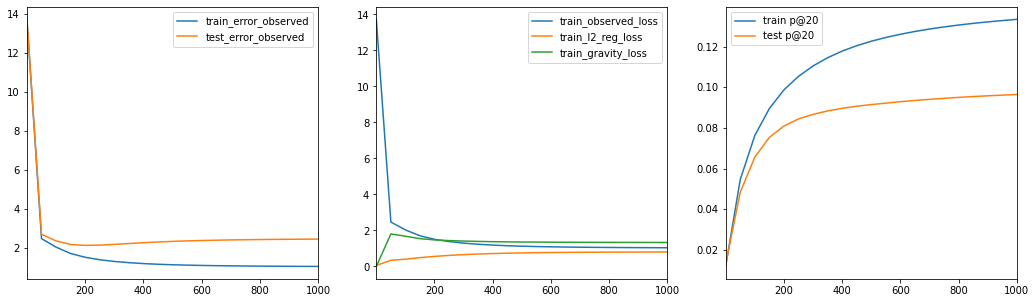

train_error_observed 	 = 1.040856
test_error_observed 	 = 2.446156
train_observed_loss 	 = 1.040856
train_l2_reg_loss 	 = 0.807339
train_gravity_loss 	 = 1.335407
train p@20 	 = 0.133424
test p@20 	 = 0.096436


In [ ]:
reg_model = build_model(
    ratings, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=30,
    init_stddev=0.1, recall_position=20)
results = reg_model.train(num_iterations=1000, learning_rate=20.)

Observe that adding the regularization terms results in a higher MSE, both on the training and test set. However, as we will see, the quality of the recommendations improves. This highlights a tension between fitting the observed data and minimizing the regularization terms. Fitting the observed data often emphasizes learning high similarity (between items with many interactions), but a good embedding representation also requires learning low similarity (between items with few or no interactions).

### Inspect the results
Let's see if the results with regularization look better.

In [ ]:
movie_neighbors(reg_model, "Aladdin", DOT)
movie_neighbors(reg_model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,dot score,titles,genres
173,8.103,Raiders of the Lost Ark (1981),Action-Adventure
94,7.969,Aladdin (1992),Animation-Children-Comedy-Musical
171,7.933,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
68,7.850,Forrest Gump (1994),Comedy-Romance-War
21,7.637,Braveheart (1995),Action-Drama-War
70,7.527,"Lion King, The (1994)",Animation-Children-Musical


Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,cosine score,titles,genres
94,1.000,Aladdin (1992),Animation-Children-Comedy-Musical
70,0.920,"Lion King, The (1994)",Animation-Children-Musical
587,0.863,Beauty and the Beast (1991),Animation-Children-Musical
27,0.842,Apollo 13 (1995),Action-Drama-Thriller
418,0.813,Mary Poppins (1964),Children-Comedy-Musical
68,0.809,Forrest Gump (1994),Comedy-Romance-War


Here we compare the embedding norms for `model` and `reg_model`. Selecting a subset of the embeddings will highlight them on both charts simultaneously.

In [ ]:
movie_embedding_norm([model, reg_model])

alt.HConcatChart(...)

In [ ]:
# Visualize the embeddings
umap_movie_embeddings(reg_model)

Running UMAP...


alt.HConcatChart(...)

We should observe that the embeddings have a lot more structure than the unregularized case. Try selecting different genres and observe how they tend to form clusters (for example Horror, Animation and Children).

### Conclusion
This concludes this section on matrix factorization models. Note that while the scale of the problem is small enough to allow efficient training using SGD, many practical problems need to be trained using more specialized algorithms such as Alternating Least Squares.

## Congratulations!

You have completed this Colab notebook.

If you would like to further explore these models, we encourage you to try different hyperparameters and observe how this affects the quality of the model and the structure of the embedding space. Here are some suggestions:
- Change the embedding dimension.
- In the softmax model: change the number of hidden layers, and the input features. For example, you can try a model with no hidden layers, and only the movie ids as inputs.
- Using other similarity measures: In this Colab notebook, we used dot product $d(u, V_j) = \langle u, V_j \rangle$ and cosine $d(u, V_j) = \frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$, and discussed how the norms of the embeddings affect the recommendations. You can also try other variants which apply a transformation to the norm, for example $d(u, V_j) = \frac{\langle u, V_j \rangle}{\|V_j\|^\alpha}$.